In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

np.set_printoptions(suppress=True)
path = '/Users/tae/Desktop/Project/Dataset/unnormalize/dataset.xlsx'
# path = 'https://github.com/taesaksit/project/raw/main/Normalize48.xlsx'

size_feature = 512
size_row = 4




In [151]:
def n_fold():
    

    data = pd.read_excel(path)

    print(data)
    
    dc1 = data[data['class']==1]
    dc2 = data[data['class']==2]
    dc3 = data[data['class']==3]
    dc4 = data[data['class']==4]

    a1 = len(dc1) // 10-1
    a2 = len(dc2) // 10-1
    a3 = len(dc3) // 10-1
    a4 = len(dc4) // 10-1

        

    train = np.empty(10 , dtype='object')
    test = np.empty(10 , dtype='object')

    for cj in range(1,11):
        
        if cj == 10:
            
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = len(dc1)
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = len(dc2)
            
            stdc3 = (cj-1) * (a3+1);
            ftdc3 = len(dc3)
            
            stdc4= (cj-1) * (a4+1);
            ftdc4 = len(dc4)
            
        else:
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = stdc1+a1
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = stdc2+a2
            
            stdc3 = (cj-1) * (a3+1)
            ftdc3 = stdc3+a3
            
            stdc4 = (cj-1) * (a4+1)
            ftdc4 = stdc4+a4
            
        Dtest1 = dc1[stdc1:ftdc1+1]
        Dtest2 = dc2[stdc2:ftdc2+1]
        Dtest3 = dc3[stdc3:ftdc3+1]
        Dtest4 = dc4[stdc4:ftdc4+1]

        Dtrain1 = dc1.drop(dc1.index[stdc1:ftdc1+1])
        Dtrain2 = dc2.drop(dc2.index[stdc2:ftdc2+1])
        Dtrain3 = dc3.drop(dc3.index[stdc3:ftdc3+1])
        Dtrain4 = dc4.drop(dc4.index[stdc4:ftdc4+1])


        
        
    
        test[cj-1] =  pd.concat([Dtest1, Dtest2,  Dtest3 , Dtest4],ignore_index=True).to_numpy()
        train[cj-1] = pd.concat([Dtrain1,Dtrain2, Dtrain3 ,Dtrain4], ignore_index=True).to_numpy()
        
       
    
    return train , test
    

In [152]:
def initial_pop(size=10):
    
    c_whale = np.empty(size , dtype='object')
    for i in range(size):
        c_whale[i] = np.random.random(size=(size_row,size_feature))
        
    return c_whale


In [153]:
def evaluate_fitness(population, data_train):

    perform = []

    for i in range(len(population)):
        count = 0
        
        wp = population[i]
        
        for j in range(len(data_train)):
            clone_data = np.tile( data_train[j ,:size_feature] , (size_row,1))
            dis = np.sqrt( np.sum((clone_data - wp)**2 , axis=1)  )

            
            if np.argmin(dis)+1 == data_train[j , size_feature : size_feature+1]:
                count = count + 1
        perform.append((i, count))
                
    score = np.array(perform)
    gbest = population[np.argmax(score[:,1])]
        
    return  score , gbest
    

In [154]:
def sort_value(score):
  
    index = np.argsort(score[:, 1])[::-1]
    top_ten = score[index][:10]
    max_fit = score[index][0, 1]
    indexs = index[:10]

    return  top_ten , max_fit , indexs

In [155]:
def test_model(model , dataTest):
    
    only_data = dataTest[:,:size_feature]
    class_data = dataTest[:,size_feature:size_feature+1]
    count = 0
    
    for i in range(len(dataTest)):
        md = np.tile(only_data[i] , (size_row,1))
        dis = np.sqrt( np.sum((model - md)**2 , axis=1) )
        
        if np.argmin(dis)+1 == class_data[i]:
            count = count+1
    
    return count

In [198]:
def woa(population , gbest , train):
    
    best_value = []
    max_iter = 300
    pxi = 0.5
    imax_fit = 0
    repeat = 0
    count = 0
    threshold = 0.03 * max_iter


    a_min = 0
    a_max = 1
    w_variation = 0.05
    
    for i in range(max_iter+1): 
        
        a =   (2-2 * (i/max_iter)) 

        l = (a - 1) * np.random.random(size=(size_row, size_feature)) + 1
        A = 2*a*np.random.random(size=(size_row, size_feature))-a
        C = 2 * np.random.random(size=(size_row, size_feature))
        
        if repeat >=250:
            break
        
        new_population = np.empty(10, dtype='object')
        
        for j in range(len(population)):
            w_pop = population[j]
            
            if np.random.random() < pxi:
                
                if np.abs(np.sum(A)) > 1:
                    w_rand = np.random.choice(population)
                    D_x = np.sqrt( np.sum( ( (C * w_rand) - w_pop)**2, axis=1  ) ).reshape(size_row,1)                    
                    wpop = w_rand - (A * D_x)
                    
                else:
                    D_x = np.sqrt( np.sum( ( (C * gbest) - w_pop)**2, axis=1  ) ).reshape(size_row,1)
                    wpop = gbest - (A * D_x)
                    
            else:
                w_dist = np.sqrt( np.sum((gbest - w_pop)**2, axis=1 )).reshape(size_row,1)
                wpop = (w_dist * np.exp(l) * np.cos(l * 2 * np.pi)) + gbest 
                

            new_population[j] = np.clip(wpop , a_min=a_min , a_max=a_max) 
        
        # Combined old+new
        combined = np.concatenate((population, new_population))
        score, gbest = evaluate_fitness(combined,train)
        
        #sort data 
        top_ten , max_fit , new_index = sort_value(score)
        
        #replace population
        population = combined[new_index]
        best_value.append((i,  max_fit))
        
        if imax_fit == max_fit:
            count = count + 1
        else:
            imax_fit = max_fit
            count = 0
            
        #Check Threshold 
        if count > threshold:
            count = 0
            repeat = repeat + 1

            # กรณีติด local
            for x in range(1,len(population)):
                if x in {1,2,3}:
                    newW = (w_variation * np.random.random(size=(size_row,size_feature))) - w_variation
                    population[x] = population[0] + newW
                else:
                    population[x] = np.random.random(size=(size_row,size_feature))
        
    index , value = zip(*best_value)
    plt.figure(figsize=(18,6))
    plt.plot(index,value, marker='o', markersize=2, linewidth=0.8)
    plt.show()

    return population[0] , best_value[-1][0], best_value[-1][1] , max_iter , best_value


In [176]:
def execute(train,test):
    
    performance = []
    iterValue = []
    graph = []
        
    for i in range(len(test)):

        test_size = len(test[i])
        # 1. initial whale
        population = initial_pop()
        # 2.fitness
        score,gbest = evaluate_fitness(population , train[i])
        # 3.train
        model, lastIter, lastValue, max_iter , best_value = woa(population,gbest,train[i])

        # 4.test
        score_model = test_model(model,test[i])
        performance.append([test_size, score_model , np.round(score_model / test_size ,3)])
        iterValue.append([len(train[i]),lastIter,lastValue])
    
    return  np.array(performance), np.array(iterValue) 


            x1        x2        x3        x4        x5        x6        x7  \
0     0.152853  0.304217  0.176726  0.496857  0.181510  1.709374  0.011629   
1     1.289420  1.111363  0.216218  0.082087  0.122154  1.187586  0.000000   
2     1.335334  0.894013  0.212585  0.175099  0.203773  1.183238  0.000000   
3     0.481517  0.089434  0.343069  1.306635  0.472123  0.101834  0.015195   
4     0.241461  0.715043  0.338380  0.831882  0.104824  0.642065  0.004337   
...        ...       ...       ...       ...       ...       ...       ...   
4057  1.128401  1.301676  1.220895  0.670779  1.364316  0.248275  0.004053   
4058  0.317392  0.374046  0.292013  0.635905  0.246244  1.209219  0.137753   
4059  1.293820  1.945504  0.447955  1.328281  0.970581  0.759954  0.098908   
4060  1.043466  0.932387  0.689709  1.181805  0.623943  0.449335  0.660194   
4061  0.462832  1.088186  0.535474  0.519907  0.297487  1.142947  0.050901   

            x8        x9       x10  ...      x504      x505    

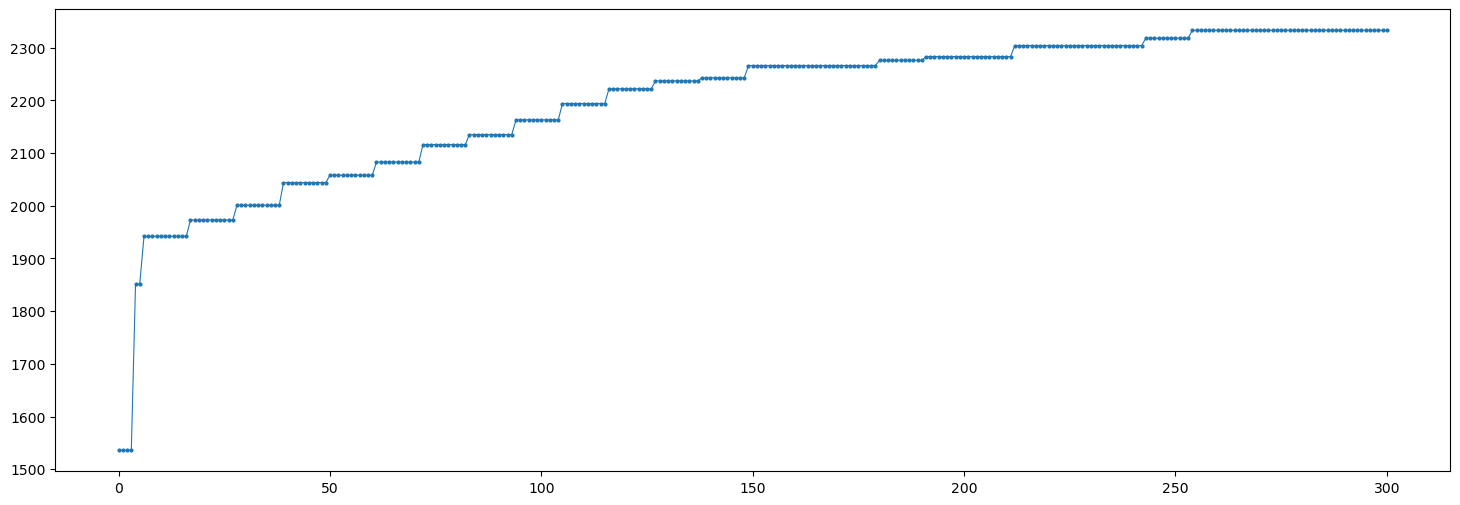

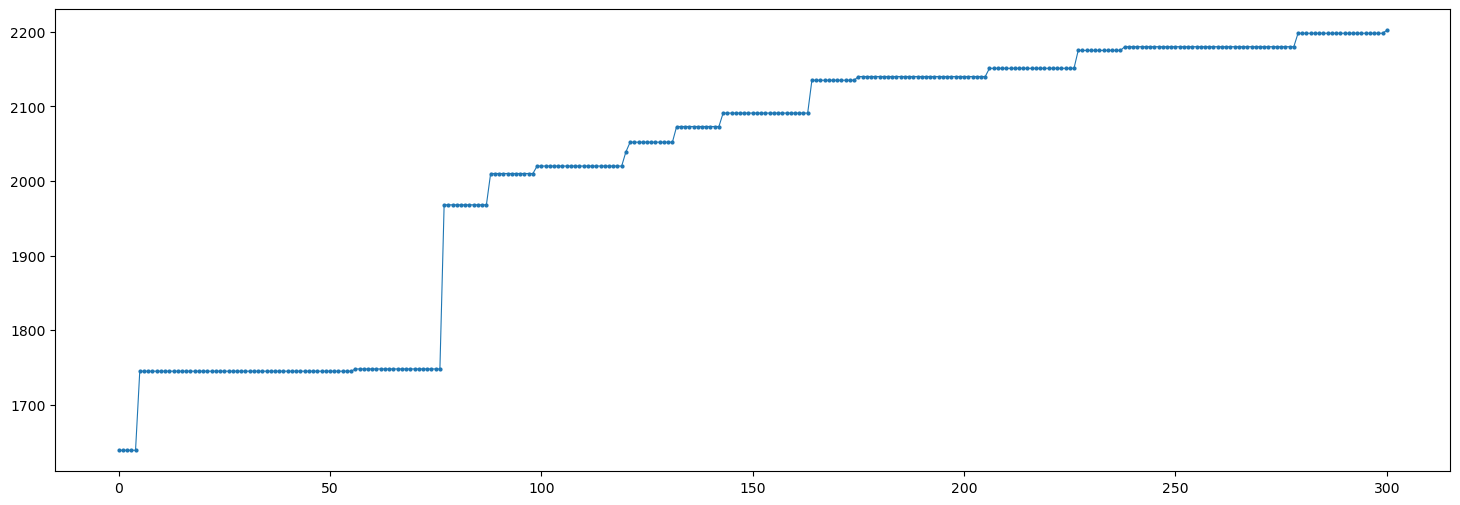

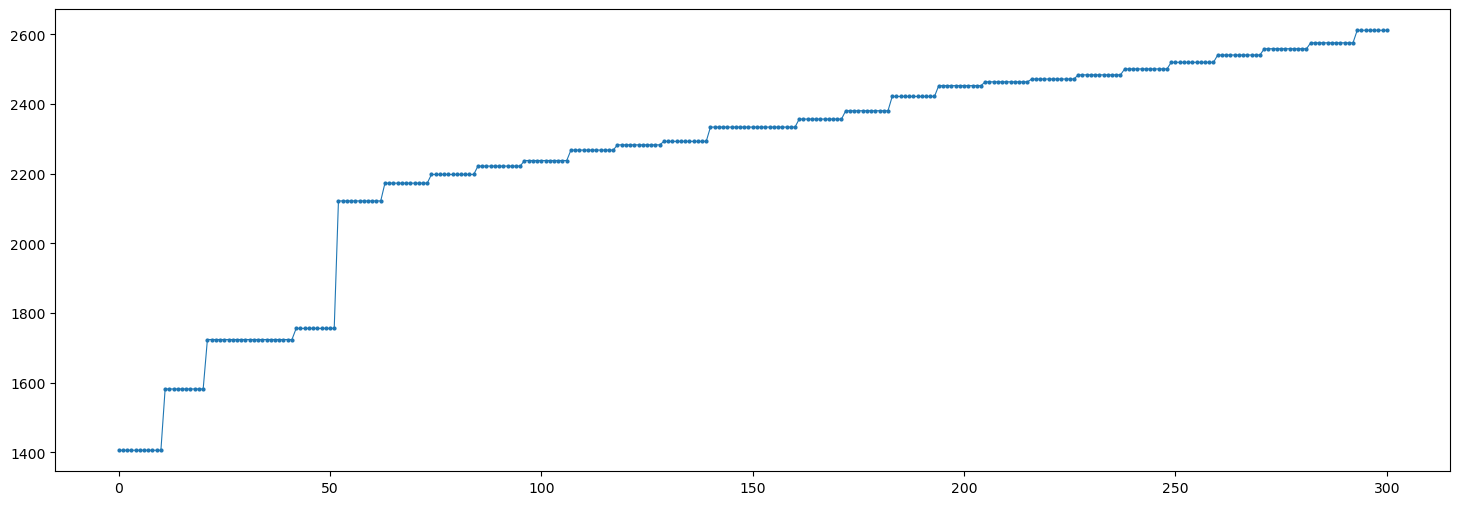

Score Test
[[405.    251.      0.62 ]
 [405.    257.      0.635]
 [405.    280.      0.691]] 

Score Train
[[3657  300 2333]
 [3657  300 2202]
 [3657  300 2612]]


In [206]:

train , test = n_fold()
perform , value  = execute(train[:3], test[:3])
print('Score Test')
print(perform , '\n')
print('Score Train')
print(value)